In [22]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from glob import glob
from collections import Counter
from pathlib import Path
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import utils.merge_tools as M

pd.set_option('future.no_silent_downcasting', True)

In [2]:
base_file = '../data/raw/parquet_files/train/train_base.parquet'
raw_data_dir = '../data/raw/parquet_files/train/'

## Investigation into Credit Bureau A Depth 2

**NOTE:** A single DataFrame will be used as the accumulated size of DataFrames will crash kernel.

### Loading, Joining, and Trimming Data

Initial cleaning and flagging of null data also performed.

In [3]:
# File group
cb_a_2 = 'train_credit_bureau_a_2'
cb_a_paths = glob(os.path.join(raw_data_dir, cb_a_2) + '*')

# Merge files in polars DataFrame
pl_df = M.load_data_group(
    group_name=cb_a_2, base_file_path=base_file, data_dir=raw_data_dir
)

# Drop base variables
pl_df = pl_df.drop(['date_decision', 'MONTH', 'WEEK_NUM'])

# Get base file
base_df = pl.read_parquet(base_file).pipe(M.set_table_dtypes).to_pandas()

# Convert string cols to categorical
cat_cols = [ col for col in pl_df.columns if pl_df[col].dtype == pl.String ]
pl_df = pl_df.with_columns(pl.col(cat_cols).cast(pl.Categorical))

# Create is_null columns
pl_df = M.create_is_null_cols(pl_df)

# Convert to pandas DataFrame and free memory
df = pl_df.to_pandas()
del pl_df

# Create total nulls column
df = pd.concat([df, pd.Series(df.isnull().sum(axis=1), name='total_nulls')], axis=1)

Most `case_ids` have entries at depth 2 credit bureau A.

In [4]:
pct_case_ids = round(100 * len(df['case_id'].unique()) / len(base_df['case_id'].unique()), 2)
print(f'Percent of case_ids in CB Depth 2: {pct_case_ids}%')

Percent of case_ids in CB Depth 2: 90.74%


We will be using a subsample of the data while weighting heavily towards the positive case.

In [5]:
prop = 0.1
n = int(prop * len(df))
target_weight = 10

# Create weights for data points
weights = pd.Series(1, index=df.index)
weights[df.index[df['target'] == 1]] = target_weight
df = df.sample(n=n, replace=False, weights=weights, random_state=28)

In [23]:
print(df['target'].value_counts(normalize=True))

target
0    0.839601
1    0.160399
Name: proportion, dtype: float64


In [6]:
df.head(3)

,case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,...,collater_valueofguarantee_876L_is_null,pmts_dpd_1073P_is_null,pmts_dpd_303P_is_null,pmts_month_158T_is_null,pmts_month_706T_is_null,pmts_overdue_1140A_is_null,pmts_overdue_1152A_is_null,pmts_year_1139T_is_null,pmts_year_507T_is_null,total_nulls
134483396,1405274,a55475b1,a55475b1,NaN,NaN,a55475b1,a55475b1,4,1,NaN,...,True,True,False,True,False,True,False,True,False,6
101776646,743246,a55475b1,a55475b1,NaN,NaN,a55475b1,a55475b1,1,16,0.0,...,True,False,False,False,False,False,False,False,False,2
22979556,1622497,a55475b1,a55475b1,NaN,NaN,a55475b1,a55475b1,3,11,NaN,...,True,True,False,True,False,True,False,True,False,6


In [7]:
df.shape

(18829845, 31)

### Data Cleaning

In [8]:
# Get columns by type
target_col = 'target'
id_cols = ['case_id', 'num_group1', 'num_group2']
ignore_cols = [target_col] + id_cols
cat_cols = [ col for col in df.columns if (col not in ignore_cols) and (df[col].dtype == 'category') ]
num_cols = [ col for col in df.columns if (col not in ignore_cols) and (pd.api.types.is_any_real_numeric_dtype(df[col].dtype)) ]
data_cols = cat_cols + num_cols

In [9]:
# Drop columns below missing value threshold
missing_thresh = 0.95
df = df[df.columns[df.isnull().mean() < missing_thresh]]

In [10]:
# Get new columns by type
num_cols = [
    col for col in df.columns
    if (pd.api.types.is_any_real_numeric_dtype(df[col].dtype))
    and (col not in ignore_cols)
]
cat_cols = [
    col for col in df.columns
    if df[col].dtype == 'category'
]
bool_cols = [
    col for col in df.columns
    if df[col].dtype == 'bool'
]
data_cols = num_cols + cat_cols + bool_cols

We will be using all categories since there are not an excessive number of dimension per column.

In [11]:
# Uniques by categories
for col in cat_cols:
    print(f'{col} uniques: {len(df[col].unique())}')

collater_typofvalofguarant_298M uniques: 4
collater_typofvalofguarant_407M uniques: 6
collaterals_typeofguarante_359M uniques: 15
collaterals_typeofguarante_669M uniques: 15
subjectroles_name_541M uniques: 11
subjectroles_name_838M uniques: 9


In [12]:
# Fill categorical nulls
for col in cat_cols:
    df[col] = df[col].cat.add_categories(['null'])
    df[col] = df[col].fillna('null')

We will fill the remaining missing values.

In [13]:
# Remaining missing columns
missing_cols = [ 
    col for col in df.columns if df[col].isnull().sum() > 0 
]
imputer = SimpleImputer()
df[missing_cols] = imputer.fit_transform(df[missing_cols])

Scaling the numerical columns.

In [14]:
# Scale
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

One-hot encode categorical columns.

In [15]:
# One hot encode
one_hot = pd.get_dummies(df[cat_cols], drop_first=True)
df = pd.concat([df, one_hot], axis=1)
df = df.drop(columns=cat_cols)

# Get cat_cols from one hot DataFrame and free memory
cat_cols = one_hot.columns
del one_hot

### Clustering

Due to the size of the data, we will be creating cluster "profiles" of individuals associated with accounts instead of utilizing all the data.

In [16]:
cl_list = []
for i in range(2, 5):
    clusterer = MiniBatchKMeans(n_clusters=i)
    cluster_labels = clusterer.fit_predict(df.drop(columns=ignore_cols), df['target'])
    cl_df = pd.DataFrame({'cluster': cluster_labels, 'target': df['target']})
    cl_df = cl_df.groupby('cluster')['target'].value_counts(normalize=True)
    cl_list.append(cl_df)

In [17]:
cluster_dict = {'num_clusters': [], 'label': [], 'prop_positive': []}
for i in range(len(cl_list)):
    num_clusters = i + 2
    for j in range(num_clusters):
        prop_pos = cl_list[i][j][1]
        cluster_dict['num_clusters'].append(num_clusters)
        cluster_dict['label'].append(j)
        cluster_dict['prop_positive'].append(prop_pos)

In [18]:
cluster_df = pd.DataFrame(cluster_dict)
prop_pos_max = cluster_df['prop_positive'].max()
max_loc = cluster_df.loc[cluster_df['prop_positive'] == prop_pos_max][['num_clusters', 'label']]
prop_df = pd.DataFrame({'prop_positive': [df['target'].value_counts(normalize=True)[1]]})

Does not even touch being useful at this point.

In [20]:
cluster_df

,num_clusters,label,prop_positive
0,2,0,0.166782
1,2,1,0.149713
2,3,0,0.172543
3,3,1,0.144077
4,3,2,0.166120
5,4,0,0.170499
6,4,1,0.164411
7,4,2,0.150182
8,4,3,0.164079


### PCA

In [24]:
X = df.drop(columns=ignore_cols)
y = df['target']

In [26]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)

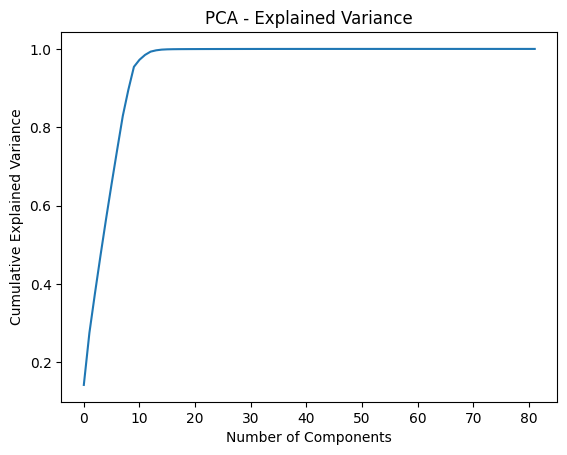

In [27]:
plt.plot(cumsum)
plt.title('PCA - Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

In [28]:
# Get number of components
d_99 = np.argmax(cumsum >= 0.99) + 1
d_95 = np.argmax(cumsum >= 0.95) + 1

print(f'99% Explained Variance: {d_99} components')
print(f'95% Explained Variance: {d_95} components')

99% Explained Variance: 13 components
95% Explained Variance: 10 components


In [29]:
# Fit
pca_95 = PCA(n_components=d_95)
pca_95.fit(X)

# Transform
X_train_pca_95 = pca_95.transform(X)

In [39]:
pca_df = pd.concat([
    pd.DataFrame(X_train_pca_95, index=df.index, columns=[ f'pca_{i+1}' for i in range(X_train_pca_95.shape[1])]), 
    df['target']
], axis=1)

No real separation.

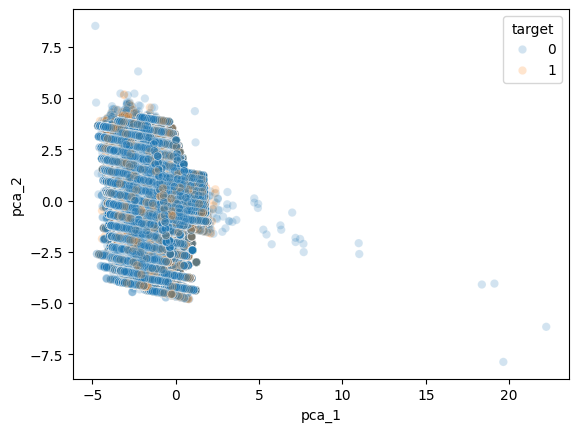

In [44]:
sns.scatterplot(data=pca_df, x='pca_1', y='pca_2', hue='target', alpha=0.2)

plt.show()

In [45]:
os.system('say "beep beep."')

0